This notebook uses the q_learning_lib.py to perform Q-learning on tic tac toe.

A variation of different hyperparameters are tried, against many different cases.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import q_learning_lib as qlb
import json
import os

Assuming alpha = 0.1 and tau = e, lets record what happens in each of the 4 cases of training (optimal, non optimal, x, o)

In [2]:
NUMBER_OF_BATCHES = 1000
BATCH_SIZE = 10
NUMBER_OF_GAMES = NUMBER_OF_BATCHES * BATCH_SIZE

In [3]:
def make_alpha(rate_val):
    """Function factorie for creating different alpha functions"""
    def alpha(turn):

        #return rate_val * (BATCH_SIZE * NUMBER_OF_BATCHES - turn) / (NUMBER_OF_BATCHES * BATCH_SIZE)
        #return 0.5 / (1 + rate_val * turn) 

        return 0.5 * np.exp(-rate_val * turn) #my new proposed fucntion

    return alpha

def make_tau(rate_val):
    """Function factorie for creating different tau functions"""
    def tau(turn):
        #return 1 + max_rate * (turn) / (NUMBER_OF_BATCHES * BATCH_SIZE) 
        #return 1 + (max_rate - 1) * ((turn/(NUMBER_OF_BATCHES * BATCH_SIZE))**3)
        return np.pow(10000, np.pow(turn/(NUMBER_OF_GAMES), rate_val )) #my new proposed function

    return tau


In [4]:

def record_params(results, filename):

    df = pd.DataFrame(results[::-1], columns=['o_win', 'draw', 'x_win'])

    # Save to CSV (index=False prevents it from adding a row-number column)
    df.to_csv(filename, index=False)

In [5]:
alpha_exponents = np.linspace(-4, -10, 10)
alpha_values = np.pow(10, alpha_exponents)
tau_exponents = np.linspace(-3, 3, 10 )
tau_values = np.pow(10, tau_exponents)
print(alpha_values)
print(tau_values)
print(tau_exponents)

[1.00000000e-04 2.15443469e-05 4.64158883e-06 1.00000000e-06
 2.15443469e-07 4.64158883e-08 1.00000000e-08 2.15443469e-09
 4.64158883e-10 1.00000000e-10]
[1.00000000e-03 4.64158883e-03 2.15443469e-02 1.00000000e-01
 4.64158883e-01 2.15443469e+00 1.00000000e+01 4.64158883e+01
 2.15443469e+02 1.00000000e+03]
[-3.         -2.33333333 -1.66666667 -1.         -0.33333333  0.33333333
  1.          1.66666667  2.33333333  3.        ]


In [6]:
def try_different_hyperparams(alpha_rates, tau_rates, player, strategy, folder=""):
    """this functions tries a variation of different hyperparameters
    results from every single iteration are saved in a .csv file
    how alpha params, tau values affect the final winrates is recorded in a pandas df and also saved to a file """
 
    df_list = [] #will be turned to a df later
    
    for a, alpha_rate in enumerate(alpha_rates): 
        for b, tau_rate in enumerate(tau_rates):

            #trains
            Q_Table_x_optimal, results = qlb.perform_training(player, strategy, NUMBER_OF_BATCHES, BATCH_SIZE, False, make_alpha(alpha_rate), make_tau(tau_rate))

            results = results/(BATCH_SIZE * 50)
        
            #records the resultsplayer_x_label='x', player_o_label='o', 
            filename = f"parameter_results/{player}_vs_{strategy}/_opponent_alpha_{alpha_rate}_tau_{tau_rate}.csv"
            record_params(results, filename)

            
            #records end winrates vs hyperparams
            o_winrate = np.mean(results[:, 0][-5:])
            drawrate = np.mean(results[:, 1][-5:])
            x_winrate = np.mean(results[:, 2][-5:])
            new_results = {'alpha_rate': alpha_rate, 'tau_rate': tau_rate, 'o_winrate': o_winrate, 'drawrate': drawrate, 'x_winrate': x_winrate}
            df_list.append(new_results)

            print(f"{player}_vs_{strategy}: {((a * 10 + b + 1)/(len(alpha_rates) * len(tau_values))) * 100:.2f}%")
            print(f"'alpha_rate' {alpha_rate}, 'tau_rate': {tau_rate}, 'o_winrate': {o_winrate:.3f}, 'drawrate': {drawrate:.3f}, 'x_winrate': {x_winrate:.3f}")

    df = pd.DataFrame(df_list) 
    df.to_csv(f"parameter_results/{player}_vs_{strategy}/hyperparams.csv", index=False)

In [7]:
#try_different_hyperparams(alpha_values, tau_values, 'x', 'perfect')
#try_different_hyperparams(alpha_values, tau_values, 'o', 'perfect')
#try_different_hyperparams(alpha_values, tau_values, 'x', 'random')
#try_different_hyperparams(alpha_values, tau_values, 'o', 'random')


In [8]:
df = pd.read_csv('parameter_results/x_vs_perfect/hyperparams.csv')

Text(0.5, 1.0, 'Max drawrate achieved 99.80%')

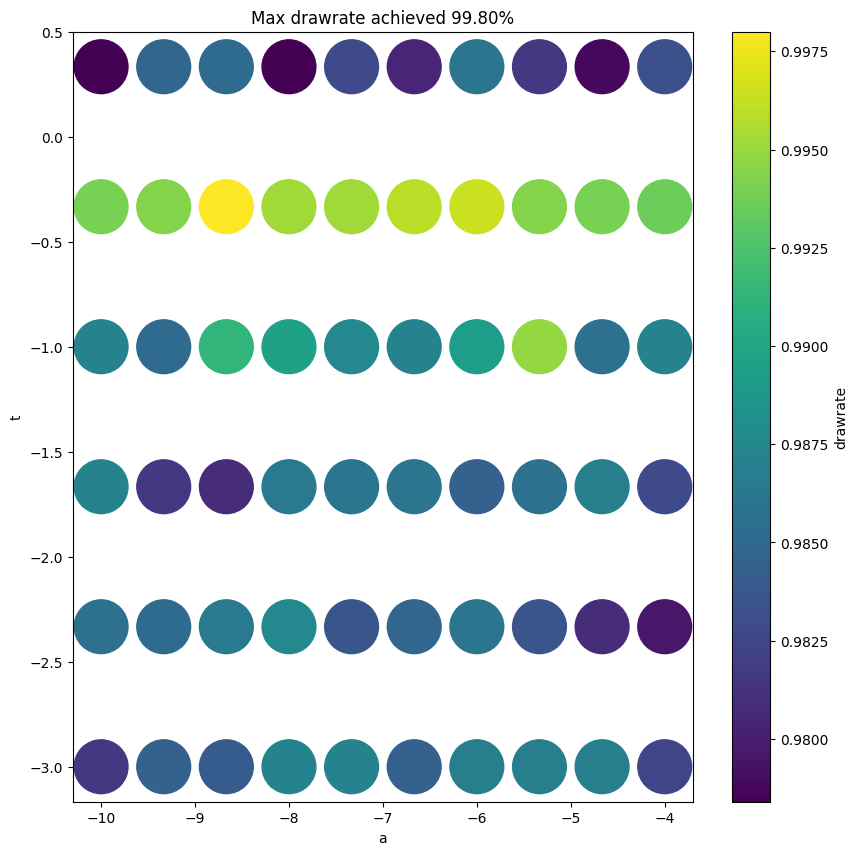

In [9]:
# 1. Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

mask = df[np.log10(df['tau_rate']) < 1]#[np.log10(df['alpha_rate']) <= -4][np.log10(df['tau_rate']) <= -2]

x = np.log10(mask['alpha_rate'])
y = np.log10(mask['tau_rate'])
z = mask['drawrate']

# 2. Capture the return value (the "mappable")
scatter = ax.scatter(x, y, c=z, s=1500, cmap='viridis') # cmap is optional but recommended

# 3. Pass the scatter object to the colorbar
fig.colorbar(scatter, ax=ax, label=z.name)
ax.set_xlabel('a')
ax.set_ylabel('t')
ax.set_title(f"Max {z.name} achieved {z.max() * 100 :.2f}%")

I have found good parameters for alpha rate and tau rate which should be implemented:

alpha_rate 10^-7

tau_rate = 10^-0.333


Now the goal is to create a matrix:

I will train 4 models on those parameters and record the results after playing 1000 games against each other using tau as the softmax

In [10]:
alpha = make_alpha(np.pow(10.0, -7))
tau = make_tau(np.pow(10.0, -1/3))

Q_Table_X_Perfect, results = qlb.perform_training('x', 'perfect', NUMBER_OF_BATCHES, BATCH_SIZE, False, alpha, tau)
print(results[-1, :])
Q_Table_X_Random, results = qlb.perform_training('x', 'random', NUMBER_OF_BATCHES, BATCH_SIZE, False, alpha, tau)
print(results[-1, :])
Q_Table_O_Perfect, results = qlb.perform_training('o', 'perfect', NUMBER_OF_BATCHES, BATCH_SIZE, False, alpha, tau)
print(results[-1, :])
Q_Table_O_Random, results = qlb.perform_training('o', 'random', NUMBER_OF_BATCHES, BATCH_SIZE, False, alpha, tau)
print(results[-1, :])

[  1 499   0]
[  4   7 489]
[  0 500   0]
[420  36  44]


In [11]:
Q_Table_X_Perfect, results = qlb.perform_training('x', 'perfect', NUMBER_OF_BATCHES, BATCH_SIZE, True, alpha, tau)

o win   draw    x win
50
74.60%   25.40%   0.00%
100
57.40%   42.60%   0.00%
150
29.00%   71.00%   0.00%
200
19.20%   80.80%   0.00%
250
9.00%   91.00%   0.00%
300
8.40%   91.60%   0.00%
350
6.20%   93.80%   0.00%
400
4.60%   95.40%   0.00%
450
1.20%   98.80%   0.00%
500
2.60%   97.40%   0.00%
550
1.80%   98.20%   0.00%
600
2.00%   98.00%   0.00%
650
1.60%   98.40%   0.00%
700
1.00%   99.00%   0.00%
750
1.20%   98.80%   0.00%
800
0.40%   99.60%   0.00%
850
0.40%   99.60%   0.00%
900
0.80%   99.20%   0.00%
950
0.60%   99.40%   0.00%


In [ ]:

number_of_games_in_the_match = 10000
results_x_perfect_vs_o_perfect = qlb.Q_Table_match(Q_Table_X_Perfect, Q_Table_O_Perfect, number_of_games_in_the_match, 'softmax', 10)
results_x_perfect_vs_o_random = qlb.Q_Table_match(Q_Table_X_Perfect, Q_Table_O_Random, number_of_games_in_the_match, 'softmax', 10)
results_x_random_vs_o_perfect = qlb.Q_Table_match(Q_Table_X_Random, Q_Table_O_Perfect, number_of_games_in_the_match, 'softmax', 10)
results_x_random_vs_o_random = qlb.Q_Table_match(Q_Table_X_Random, Q_Table_O_Random, number_of_games_in_the_match, 'softmax', 10)
results_fully_random_game = qlb.Q_Table_match(Q_Table_X_Perfect, Q_Table_O_Perfect, number_of_games_in_the_match, 'softmax', 1)
results_another_fully_random_game = qlb.play_random_match(number_of_games_in_the_match)

results_from_matches = [results_x_perfect_vs_o_perfect, results_x_perfect_vs_o_random, results_x_random_vs_o_perfect, results_x_random_vs_o_random, results_fully_random_game, results_another_fully_random_game]

for result_from_match in results_from_matches:
    
    print(result_from_match/np.sum(result_from_match))


[0.2804 0.1451 0.5745]
[0.5407 0.1604 0.2989]
[0.1307 0.0855 0.7838]
[0.3682 0.1157 0.5161]
[0.2858 0.1277 0.5865]
[0.2919 0.1285 0.5796]
_________
[0.278  0.1423 0.5797]
[0.5414 0.1624 0.2962]
[0.1375 0.0874 0.7751]
[0.3701 0.1187 0.5112]
[0.2866 0.1267 0.5867]
[0.2952 0.1233 0.5815]
_________
[0.2726 0.138  0.5894]
[0.5457 0.1611 0.2932]
[0.1401 0.0901 0.7698]
[0.3653 0.1202 0.5145]
[0.2894 0.1314 0.5792]
[0.2893 0.1256 0.5851]
_________


**Final results are:**

[0.278  0.1423 0.5797]

[0.5414 0.1624 0.2962]

[0.1375 0.0874 0.7751]

[0.3701 0.1187 0.5112]


***Next stage is to compare the theoretically generated Q-Tables and the actual Q-Table that was made during learning***

In [19]:
#comparing perfect Q-Tables

perfect_theoretical_Q_Table = qlb.import_perfect_Q_Table()

for state in perfect_theoretical_Q_Table:
    
    if state.count("_") % 2 == 1:
        print(state)

ox_xoxoox
oxxxo_oox
oxxxoxoo_
oxo_xxoox
oxox_xoox
oxoxx_oox
_xooxxxoo
x_ooxxxoo
xxoo_xxoo
xxoox_xoo
xxooxx_oo
o_xxxooox
ox_xxooox
oxx_xooox
oxxx_ooox
oxxxxooo_
_oxxooxxo
xox_ooxxo
xoxxoo_xo
_ooxoxoxx
xoo_oxoxx
xooxo_oxx
xooxoxo_x
xooxoxox_
_xxxoooox
x_xxoooox
xx_xoooox
_xxxxoooo
x_xxxoooo
xx_xxoooo
_xxoxxooo
x_xoxxooo
xx_oxxooo
oooxxo_xx
oooxxox_x
oooxxoxx_
o_xxoooxx
ox_xoooxx
oxx_oooxx
oxxxooo_x
oxxxooox_
xo_ooxoxx
xoxoo_oxx
xoxooxox_
xxo_xxooo
xxox_xooo
xxoxx_ooo
_xooxoxox
xxoo_oxox
xxooxoxo_
ooxx_xxoo
xoo_xxoxo
xoox_xoxo
xooxx_oxo
o_oxxooxx
oxox_ooxx
oxoxxoo_x
ox_oxxxoo
oxxo_xxoo
oxxoxx_oo
ooxooxxx_
ooxoxo_xx
o_xxxooxo
oxxx_ooxo
oxxxxoo_o
o_ooxxoxx
oxoo_xoxx
oxooxxo_x
_oxoxxoxo
xo_oxxoxo
xoxo_xoxo
xoxox_oxo
xoxoxxo_o
oo_xoxoxx
ooxxo_oxx
ooxxoxox_
o_ooxxxxo
oxoo_xxxo
oxooxxx_o
ox_oxxoox
oxxox_oox
oxxoxxoo_
o_oxoxoxx
oxo_oxoxx
oxoxo_oxx
oxoxoxo_x
oxoxoxox_
_oooxxxox
xooo_xxox
xoooxxxo_
_xoxoooxx
x_oxoooxx
xxo_oooxx
xxoxooo_x
xxoxooox_
_xxooxxoo
x_xooxxoo
xx_ooxxoo
x_oxxooxo
xxox_ooxo
